# Case Study: distance estimation 

In this case study, we will estimate the .........

## 1. Import code 

In [25]:
# Import dependencies
import os
from cvzone.FaceMeshModule import FaceMeshDetector 
import matplotlib.pyplot as pyplot

## 2. Distance estimation function

In [15]:
# Average distance between the eyes in cm 
INTEROCULAR_DISTANCE = 6.3

# Focal length of the camera in use (in some unit)
focal_length = 655

# Face mesh detector configured to detect a maximum of one face
CVZONE_DETECTOR_MAX_ONE = FaceMeshDetector(maxFaces=1)

# Constants for CVZone face mesh indices for eye locations
EYE_DISTANCE_INDEX = {
    'left_eye': 145,
    'right_eye': 374
}

# Function for estimating distance 
def estimate_depth(landmarks: list[list[int]], focal_length):
    """Estimate the Z-coordinate (depth) for a detected face.

    This function calculates the depth, which is the distance between the screen and the user, using a method that relies on the distance between the eyes. 
    It uses the focal length and the average distance between the eyes, to estimate the depth based on eye landmarks detected. 

    Parameters:
        landmarks (list[list[int]]): A list of arrays, each array representing a landmark with x and y position of that landmark.

    Returns:
        int: The distance between the user and the camera 
    
    """
    # Check that the list has the 468 landmarks 
    if len(landmarks) != 468:
        print("ERROR: Invalid length of landmark list expected 468, was {len(landmarks)}")
        return None 
    
    # Retrieve the eye indexes 
    left_eye = landmarks[EYE_DISTANCE_INDEX['left_eye']]
    right_eye = landmarks[EYE_DISTANCE_INDEX['right_eye']]

    # Calculate distance between eyes
    w, _ = CVZONE_DETECTOR_MAX_ONE.findDistance(left_eye, right_eye)
    
    # Estimate depth
    return int((INTEROCULAR_DISTANCE * focal_length) / w)

I0000 00:00:1714639771.170226    5141 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714639771.171866    9167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: RENOIR (renoir, LLVM 15.0.7, DRM 3.54, 6.5.0-28-generic)


## 3. Dataset 

The dataset is created by us to check the distance estimation is correct. 
The images are labeled by a ground truth measured in inches. 

The following distances are in out custom dataset: 

- 20 inches
- 30 inches
- 40 inches
- 50 inches
- 60 inches
- 70 inches
- 80 inches

The range is from 20 inches (50.8 cm) to  80 inches (203.2 cm). This range covers the desired testing range as mentioned in the goals for this thesis. 

Run the code block below to verify that the dataset exists:

In [16]:
# Verify the data set 
dataset_dir = "./datasets/distance_dataset/"

# List of expected file names
files_to_check = [
    "20inches.jpg", "30inches.jpg", "40inches.jpg",
    "50inches.jpg", "60inches.jpg", "70inches.jpg",
    "80inches.jpg"
]

# Check if each file exists in the directory
for filename in files_to_check:
    file_path = os.path.join(dataset_dir, filename)
    assert os.path.exists(file_path), f"Was not able to find: {file_path}"

All the images has been labeled manually. For each distance, each x and y position of each eye are set. You can expect some reasonable error with this labeling, but the error rate should be relatively low. 

The labeled information can be found in the file: `./datasets/distance_dataset/eye_positions.txt`.

Run the following code block to setup the mock output for the CVZone face detection model. 
**Note:** The output is mocked due to the avoid that face detection model is also tested. This is not the purpose of **this** case study.

In [17]:
# Define the dictionary for eye distance index
EYE_DISTANCE_INDEX = {
    'left_eye': 145,
    'right_eye': 374
}

# Define the positions for each image
eye_positions = {
    20: {"left": [1180, 525], "right": [1340, 525]},
    30: {"left": [1198, 625], "right": [1320, 625]},
    40: {"left": [1183, 670], "right": [1270, 670]},
    50: {"left": [1298, 703], "right": [1369, 703]},
    60: {"left": [1295, 751], "right": [1359, 751]},
    70: {"left": [1354, 773], "right": [1403, 773]},
    80: {"left": [1322, 754], "right": [1366, 754]}
}

# Create the map of landmarks
# The key is how many inches the user is away from the camera
# The value is the mocked output from CVZone
landmark_map = {}

# Setting up the map based on the positions 
for inch, pos in eye_positions.items():
    # Create a list of 468 elements initialized with None
    landmarks = [[0, 0] for _ in range(468)]
    
    # Set the left and right eye positions
    landmarks[EYE_DISTANCE_INDEX['left_eye']] = pos['left']
    landmarks[EYE_DISTANCE_INDEX['right_eye']] = pos['right']
    
    # Store in the map
    landmark_map[inch] = landmarks
 

## 4. Calculate the focal length

Focal length can be calculated with the following equation: 

$$ \frac{1}{F} = \frac{1}{O} + \frac{1}{L} $$

Where: 
- F: Focal length of the camera
- O: distance between the lens and the object
- L: distance between the lens and the image 


The following function calculated the focal length based on this equation: 

In [18]:
# Function for the calculation for the focal length 
def calculate_focal_length(object_distance, image_distance):
    return 1 / ((1 / image_distance) + (1 / object_distance)) 


## 5. Estimating the focal length 

To find the focal length, we are going to be using polynomial regression. This is when you have a set data points that are nonlinear, and you try to estimate a curve to that fits the best for all data points. We have our mocked data from the faces, and from that we have the distances for each given the focal length. 

To do polynomial regression we are going to be calculating the error rate for each distance estimation, and then use that error rate to change the focal length. The goal is to minimize the error rate (which is the difference between the distance and the ground truth distance). Then we are going to iterate over all datasets until we hit a max amount of iterations or that the average error rate is lower than a set tolerance. 

The following function is to make cm into inches: 


In [19]:
# Inches to cm converter function
def to_cm(inches):
    return inches * 2.54

The `adjust_focal_length` function adjust the estimated focal length based on the error rate. It calculates the error as the difference between the actual distance and the detected distance. An adjustment is then made to the current focal length, scaled by a default learning rate. This adjustment is added to the current focal length to produce a new focal length, which is returned for use in new estimations. 

This process helps iteratively reduce the error rate. Run the codeblock below to save the function for the adjustment: 

In [20]:
def adjust_focal_length(detected_distance, actual_distance, current_focal_length, learning_rate):
    error = actual_distance - detected_distance
    adjustment = learning_rate * error  # Calculate the adjustment directly proportional to the error
    new_focal_length = current_focal_length + adjustment  # Update the focal length by adding the adjustment
    return new_focal_length

In our focal length estimation process, we initiate with an estimated value for the focal length. 
Then we start fitting the curve by utilize various constants to make the adjustments:

- **Errors:** An empty list initialized to collect the average error rates observed over each iteration. Will be used to plot a graph
- **Tolerance:** Defined in cm. The goal is to make the error rate be less than this tolerance. 
- **Learning Rate:** The learning rate is used to control at what rate the regression should happen. Higher learning rate leads to less iterations, but the error rate in the end will be high. To make the error rate low, the learning rate also has to be low, but this requires more iterations. 
- **Max Iterations:** A max limit for the amount of iterations 
- **Average Error:** The average error rate of the process 
- **Iterations:** Counts how many iteration has been done 

In [21]:
# Initial focal length to a guess 
focal_length = 650  

# Collecting the error rate over time: 
errors = []

# Tolerance for the average error in cm
tolerance = 2.0  

# Set the learning rate and max amount of iterations 
learning_rate = 0.04  
max_iterations = 200  

# Set the error rate to a high number 
average_error = float('inf')  

# Count how many iterations 
iterations = 0

The next code block will start to adjust the focal length:

In [22]:
while average_error > tolerance and iterations < max_iterations:
    total_error = 0  # Sum of errors for this iteration
    iterations += 1

    # Iterating over each file

    for filename in files_to_check:
        # Getting the ground truth from the file 
        ground_truth_inches = int(filename.replace('inches.jpg', ''))
        ground_truth_cm = to_cm(ground_truth_inches)

        # Using the map to mock the ground truth of the output 
        face = landmark_map[ground_truth_inches]

        estimated_depth_cm = estimate_depth(face, focal_length)
        error = abs(estimated_depth_cm - ground_truth_cm)
        total_error += error

        # Adjust the focal length for each image based on the current error
        focal_length = adjust_focal_length(estimated_depth_cm, ground_truth_cm, focal_length, learning_rate)

    if iterations > 0:
        average_error = total_error / iterations
        errors.append(average_error)
        print(f"[INFO] Iteration {iterations}: Average Error Rate = {average_error} cm, Focal Length = {focal_length}")
    else:
        print("No valid images processed. Stopping the iterations.")
        break


[INFO] Iteration 1: Average Error Rate = 482.0 cm, Focal Length = 669.2799999999999
[INFO] Iteration 2: Average Error Rate = 236.0 cm, Focal Length = 688.1599999999999
[INFO] Iteration 3: Average Error Rate = 153.0 cm, Focal Length = 706.5199999999999
[INFO] Iteration 4: Average Error Rate = 111.75 cm, Focal Length = 724.3999999999999
[INFO] Iteration 5: Average Error Rate = 87.6 cm, Focal Length = 741.9199999999998
[INFO] Iteration 6: Average Error Rate = 71.0 cm, Focal Length = 758.9599999999999
[INFO] Iteration 7: Average Error Rate = 59.42857142857143 cm, Focal Length = 775.5999999999999
[INFO] Iteration 8: Average Error Rate = 50.75 cm, Focal Length = 791.8399999999999
[INFO] Iteration 9: Average Error Rate = 43.888888888888886 cm, Focal Length = 807.6399999999999
[INFO] Iteration 10: Average Error Rate = 38.5 cm, Focal Length = 823.04
[INFO] Iteration 11: Average Error Rate = 34.27272727272727 cm, Focal Length = 838.1199999999999
[INFO] Iteration 12: Average Error Rate = 30.58333

After either the average error is lower then the tolerance, or that number of iterations is higher than the max limit. <br>
This final print statement will round the focal length and the end error rate to the closest two decimals:

In [23]:
# Printing the final Focal length 
print(f"[FINAL] Adjusted Focal Length: {round(focal_length,2)} after {iterations} iterations with average error = {round(average_error,2)} cm")

[FINAL] Adjusted Focal Length: 1249.64 after 58 iterations with average error = 2.0 cm


Also, we can plot the error rate over time, with `pyplot`: 

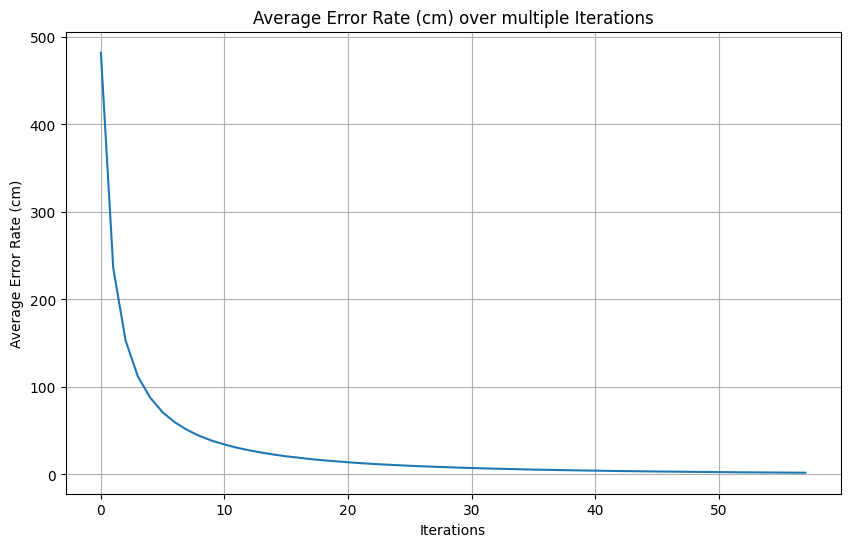

In [24]:
# Plotting the original and smoothed data
pyplot.figure(figsize=(10, 6))
pyplot.plot(errors) 
pyplot.title("Average Error Rate (cm) over multiple Iterations")
pyplot.xlabel("Iterations")
pyplot.ylabel("Average Error Rate (cm)")
pyplot.grid(True)
pyplot.show()